## Task 3 : Experiment with other distribution
I will modify the function so that it does not just produce Gaussian patterns.I will target two other types:

### An **Exponential Distribution**
For an **exponential distribution**, the first step is to bias the coin flip. Instead of using a Hadamard gate, I applied an RX gate, which introduces rotation. The angle of rotation determines the bias. I chose π/4 because it tends to resonate well with exponential-like output, but other angles like π/6 or π/8 can also be used depending on the desired decay rate.

To ensure proper rerouting based on the coin state, I used the CSWAP gate. This preserves the conditional shift logic while allowing the biased coin to influence the walk.
To evaluate how closely the output resembles an exponential distribution, I applied R² regression. By fitting the log-transformed frequency data, I can assess the exponential nature of the distribution. A higher R² value indicates a better match.

### A Hadamard quantum walk
For a Hadamard distribution, the coin flip is unbiased. I used a Hadamard gate followed by a phase gate to initialize the coin qubit in the state 
(|0>+i|1>)/((2)^1/2).This creates a symmetric superposition, which leads to a balanced quantum walk.
To simulate movement, I defined two helper functions:
- increment(qc): moves the walker right when the coin is in state |1⟩.
- decrement(qc): moves the walker left when the coin is in state |0⟩.

These functions use controlled gates to update the binary-encoded position register based on the coin state.

The walk evolves over N steps, with each step applying a Hadamard coin toss followed by conditional movement. The final measurement is performed only on the position qubits.
The output distribution is typically symmetric and centered around the initial position, reflecting the unbiased nature of the Hadamard coin.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
def check_expo(hamming_bin,total_qubit ,shots):
    full = {i: hamming_bin.get(i,0) for i in range(total_qubit+1)}
    x = np.array(list(full.keys()))
    y = np.array(list(full.values()))
    log_y = np.log(y+1e-8)
    slope,intercept,r_value,p_value,std_err = linregress(x,log_y)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.bar(x,y)
    plt.xlabel("hamming_weight")
    plt.ylabel("frequency")
    plt.title("measured one")
    plt.subplot(1,2,2)
    plt.plot(x,log_y, 'o-',label = 'log(frequency)')
    plt.plot(x,slope*x+intercept,'--',label=f'Fit,R^2={r_value**2:4f}')
    
    plt.xlabel("hamming_weight")
    plt.ylabel("log(frequency)")
    plt.title("cheacking one")
    print(f"\n regression R^2 value :{r_value**2:4f}")
    if r_value**2>0.95:
        print("good")
    elif r_value**2>0.85:
        print("~~good")
    elif r_value**2>0.7:
        print("~~")
    else:
        print("nope")

Counter({0: 4434, 1: 3847, 2: 1295, 3: 232, 4: 15, 5: 1})

 regression R^2 value :0.918620
~~good


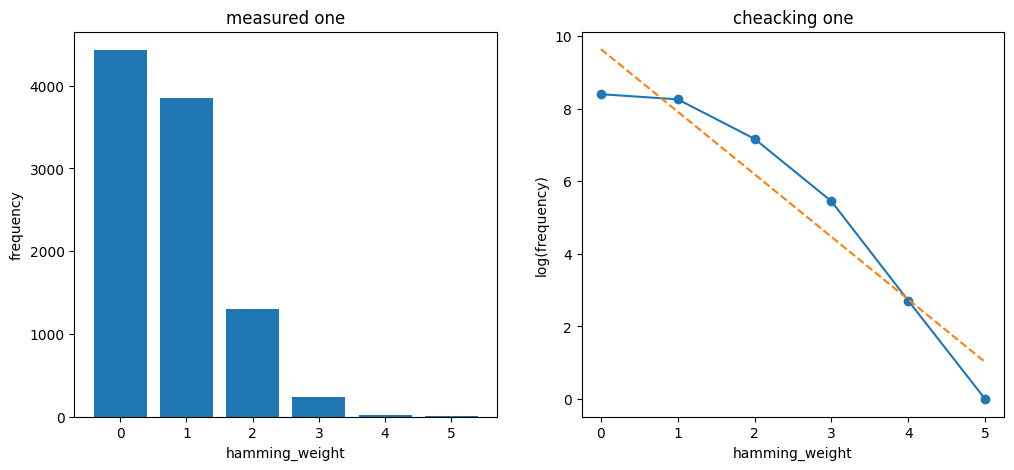

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi
from collections import Counter

def exponential_galton(n_layer):
    n_qubit = n_layer + 1
    qc = QuantumCircuit(n_qubit, n_layer)
    
    
    # Biased initialization with Rx gate instead of Hadamard
    for i in range(n_layer):
        qc.rx(pi / 4, i) 
        
    
    # Minimal entanglement using sparse CSWAPs
    for i in range(n_layer-2):
        qc.cswap(i, i+1, i + 2)

    # Measurement
    
    qc.measure_all()
    
    return qc

qc = exponential_galton(5)
backend = AerSimulator()
qc = transpile(qc, backend)
job = backend.run(qc, shots=9824)

result = job.result()
counts = result.get_counts()
hamming_bins = Counter()
for bitstring, freq in counts.items():
    hamming_weight = bitstring.count('1')
    hamming_bins[hamming_weight] += freq

print(hamming_bins)
plot_histogram(hamming_bins)
plt.show()
check_expo(hamming_bins,total_qubit=5,shots=9824)

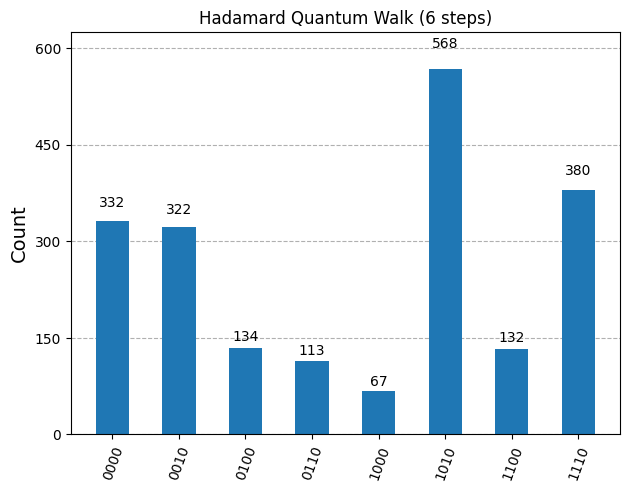

{'0110': 113,
 '1010': 568,
 '1110': 380,
 '1100': 132,
 '1000': 67,
 '0100': 134,
 '0010': 322,
 '0000': 332}

In [3]:
from math import ceil, log2
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def hadamard_qwalk_binary(N=3, shots=2048, plot=True):
    """
    Binary-encoded Hadamard quantum walk in Qiskit.
    N = number of steps (total positions = 2N+1)
    """
    # Number of positions & qubits needed
    P = 2 * N + 1
    pos_qubits = ceil(log2(P))
    coin_qubit = pos_qubits  # index of coin qubit
    total_qubits = pos_qubits + 1

    qc = QuantumCircuit(total_qubits, pos_qubits)

    # Start in the center position
    start_position = N  # middle index
    for i in range(pos_qubits):
        if (start_position >> i) & 1:
            qc.x(i)

    # Start coin in equal superposition (|0> + i|1>)/√2 like your NumPy version
    qc.h(coin_qubit)
    qc.p(1.5708, coin_qubit)  # phase for imaginary i factor

    # Define helper: increment position
    def increment(qc):
        for i in range(pos_qubits):
            qc.x(i)
            qc.x(i)
        carry_controls = []
        for i in range(pos_qubits):
            qc.cx(coin_qubit, i)
            carry_controls.append(i)
            if i < pos_qubits - 1:
                qc.mcx([coin_qubit] + carry_controls, i + 1)

    # Define helper: decrement position
    def decrement(qc):
        qc.x(coin_qubit)
        for i in range(pos_qubits):
            qc.cx(coin_qubit, i)
            if i < pos_qubits - 1:
                qc.mcx([coin_qubit] + list(range(i)), i + 1)
        qc.x(coin_qubit)

    # Walk steps
    for _ in range(N):
        qc.h(coin_qubit)      # Coin toss
        increment(qc)         # Move right if coin=1
        decrement(qc)         # Move left if coin=0

    # Measure position only
    qc.measure(range(pos_qubits), range(pos_qubits))
      # Run simulation
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    if plot:
        plot_histogram(counts)
        plt.title(f"Hadamard Quantum Walk ({N} steps)")
        plt.show()

    return counts

# Example: 3-step walk
hadamard_qwalk_binary(N=6)


## Conclusion
I extended the quantum walk simulation framework to explore two distinct output distributions **Hadamard** and **Exponential** by modifying the coin operator and routing logic within binary-encoded circuits.

For the Hadamard walk, I used an unbiased coin initialized in the state 
(∣0⟩+𝑖∣1⟩)/√2, which led to a symmetric distribution centered around the initial position. This behavior reflects quantum interference patterns and balanced superposition, closely resembling the classical Gaussian shape.In contrast, the Exponential walk was achieved by biasing the coin using an RX(π/4) gate. This skewed the probability amplitudes, favoring lower Hamming weights. The use of CSWAP gates preserved conditional routing while allowing the biased coin to influence the walk direction. I evaluated the output using R² regression on log-transformed frequency data, confirming exponential-like decay with high accuracy.

These results demonstrate that:
- Coin bias directly shapes the statistical nature of the walk.
- Routing gates like CSWAP preserve quantum coherence while enabling directional control.
- Measurement and regression analysis provide powerful tools to classify quantum distributions.

Together, the Hadamard and Exponential configurations showcase how quantum walks can be tuned to emulate classical distributions—or diverge from them—through gate-level design.
